# Libraries #

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif # Example: Filter method
from sklearn.linear_model import LogisticRegression # Example model for selection/evaluation
from sklearn.ensemble import RandomForestClassifier # Example model
from sklearn.metrics import classification_report, confusion_matrix

# Import SMOTE for class balancing
from imblearn.over_sampling import SMOTE

# Set pandas display options
pd.set_option('display.max_columns', None)

# Configuration #

In [2]:
# Define file paths (Update these paths as needed)
TRAIN_FILE_PATH = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\SWELL dataset\\data\\final\\train.csv'
TEST_FILE_PATH = 'C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\SWELL dataset\\data\\final\\test.csv'

# Define parameters
TARGET_COLUMN = 'condition'
FEATURE_COLUMNS_SLICE = slice(None, -2) # Assuming the last two columns are not features
RANDOM_STATE = 42 # For reproducibility
N_FEATURES_TO_SELECT = 50 # Define how many features to select (adjust as needed)
CV_FOLDS = 5 # Number of cross-validation folds

# Load and Initial Preprocess Data #


In [3]:
def load_and_preprocess(file_path, target_column, feature_slice):
    """Loads data, encodes target, and separates features/target."""
    df = pd.read_csv(file_path)

    # Encode the target variable
    condition_encoding = {'no stress': 0, 'time pressure': 1, 'interruption': 2}
    if target_column in df.columns:
        df[target_column] = df[target_column].map(condition_encoding)
    else:
        print(f"Warning: Target column '{target_column}' not found in {file_path}")
        return None, None # Or handle error appropriately

    # Separate features and target
    # Ensure feature_slice correctly selects your feature columns
    features = df.iloc[:, feature_slice]
    target = df[target_column]

    print(f"Loaded data from {file_path}:")
    print(f"  Features shape: {features.shape}")
    print(f"  Target distribution:\n{target.value_counts(normalize=True) * 100}\n")

    return features, target

# Load train and test data
X_train_raw, y_train = load_and_preprocess(TRAIN_FILE_PATH, TARGET_COLUMN, FEATURE_COLUMNS_SLICE)
X_test_raw, y_test = load_and_preprocess(TEST_FILE_PATH, TARGET_COLUMN, FEATURE_COLUMNS_SLICE)


Loaded data from C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\SWELL dataset\data\final\train.csv:
  Features shape: (369289, 34)
  Target distribution:
condition
0    54.180330
2    28.473634
1    17.346035
Name: proportion, dtype: float64

Loaded data from C:\Users\ferri\Downloads\PoliTO\Tesi\DSs\Emotion-Stress\SWELL dataset\data\final\test.csv:
  Features shape: (41033, 34)
  Target distribution:
condition
0    54.000439
2    28.713475
1    17.286087
Name: proportion, dtype: float64



# Data Scaling #

In [4]:
scaler = StandardScaler()

# Fit on training data and transform it
X_train_scaled = scaler.fit_transform(X_train_raw)

# Transform test data using the scaler fitted on training data
X_test_scaled = scaler.transform(X_test_raw)

print("Data Scaled.")
print(f"  X_train_scaled shape: {X_train_scaled.shape}")
print(f"  X_test_scaled shape: {X_test_scaled.shape}")

# Convert scaled arrays back to DataFrames for easier handling (optional, but useful)
# Get feature names from the original DataFrame
feature_names = X_train_raw.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

Data Scaled.
  X_train_scaled shape: (369289, 34)
  X_test_scaled shape: (41033, 34)


# Class Balancing (using SMOTE) #

In [5]:
print("Original training set distribution:")
print(y_train.value_counts(normalize=True) * 100)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nResampled training set distribution (after SMOTE):")
print(y_train_resampled.value_counts(normalize=True) * 100)

print(f"\nShape of training features after SMOTE: {X_train_resampled.shape}")

Original training set distribution:
condition
0    54.180330
2    28.473634
1    17.346035
Name: proportion, dtype: float64

Resampled training set distribution (after SMOTE):
condition
0    33.333333
2    33.333333
1    33.333333
Name: proportion, dtype: float64

Shape of training features after SMOTE: (600246, 34)


# Feature Selection (using SelectKBest) #

In [6]:
print(f"\nSelecting top {N_FEATURES_TO_SELECT} features using SelectKBest (f_classif)...")

# Initialize SelectKBest
selector = SelectKBest(score_func=f_classif, k=N_FEATURES_TO_SELECT)

# Fit on the resampled training data and transform it
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# Get selected feature names/indices
selected_indices = selector.get_support(indices=True)
selected_features = X_train_scaled.columns[selected_indices] # Get names from original scaled df
print(f"\nSelected {len(selected_features)} features:")
print(selected_features.tolist())

# Transform the original scaled test data using the fitted selector
X_test_selected = selector.transform(X_test_scaled) # Use the original test set

print(f"\nShape of training features after selection: {X_train_selected.shape}")
print(f"Shape of test features after selection: {X_test_selected.shape}")

# Convert selected arrays back to DataFrames with proper column names (optional)
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)


Selecting top 50 features using SelectKBest (f_classif)...


C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=50 is greater than n_features=34. All the features will be returned.
  warnings.warn(



Selected 34 features:
['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR', 'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF', 'HF_LF', 'sampen', 'higuci']

Shape of training features after selection: (600246, 34)
Shape of test features after selection: (41033, 34)


# Feature Fusion (Conceptual) #

In [7]:
# Feature fusion involves combining features from different sources or different representations of the same data.
#
# **Examples:**
# 1.  **Combining different sensor data:** If you had ECG features and EDA features in separate dataframes (`X_train_ecg`, `X_train_eda`), you could concatenate them:
#     `X_train_fused = pd.concat([X_train_ecg, X_train_eda], axis=1)`
# 2.  **Combining different feature extraction methods:** You might extract statistical features and frequency-domain features and combine them.
# 3.  **Using dimensionality reduction:** Techniques like PCA can be seen as a form of feature fusion/extraction, creating new components that capture variance from original features.
#
# **In this specific workflow:**
# We haven't explicitly fused *new* sources. The `X_train_selected` and `X_test_selected` dataframes represent the *result* of our preprocessing pipeline (scaling, balancing, selection) on the *original* feature set. We will now use these selected features for model training. If you had another set of features (e.g., from a different sensor or preprocessing technique), you would concatenate them *here* before feeding them to the model.
#
# For now, our "fused" (or rather, processed) features are `X_train_selected` and `X_test_selected`.

# %%
# Placeholder for actual fusion if you have multiple feature sets
# Example: Assume X_train_other_features and X_test_other_features exist
# X_train_fused = pd.concat([X_train_selected, X_train_other_features], axis=1)
# X_test_fused = pd.concat([X_test_selected, X_test_other_features], axis=1)

# For this script, we proceed with the selected features:
X_train_final = X_train_selected
X_test_final = X_test_selected
y_train_final = y_train_resampled # Use the resampled target

print("\nUsing selected features as final input for models.")
print(f"Final training features shape: {X_train_final.shape}")
print(f"Final test features shape: {X_test_final.shape}")
print(f"Final training target shape: {y_train_final.shape}")


Using selected features as final input for models.
Final training features shape: (600246, 34)
Final test features shape: (41033, 34)
Final training target shape: (600246,)


# Model Training and Evaluation #

In [8]:
def evaluate_classification(model, X_train, y_train, X_test, y_test, cv, model_name="Model"):
    """Fits, predicts, and evaluates a classification model."""
    print(f"\n--- Evaluating {model_name} ---")

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Print Classification Report
    print("\nClassification Report (Test Set):")
    report = classification_report(y_test, y_pred)
    print(report)

    # Perform Cross-Validation on the Training Set
    # Note: Using the *final* training data (X_train_final, y_train_final)
    print(f"\nCross-Validation Scores (Accuracy, {cv}-fold):")
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        print(cv_scores)
        print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except Exception as e:
        print(f"Could not perform cross-validation: {e}")


    # Compute and Plot Confusion Matrix
    print("\nConfusion Matrix (Test Set):")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_) # Use model.classes_ if available
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Logistic Regression ##


--- Evaluating Logistic Regression ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.72      0.57      0.64     22158
           1       0.42      0.70      0.52      7093
           2       0.51      0.51      0.51     11782

    accuracy                           0.57     41033
   macro avg       0.55      0.59      0.56     41033
weighted avg       0.61      0.57      0.58     41033


Cross-Validation Scores (Accuracy, 5-fold):
[0.58999584 0.59030896 0.59181667 0.58944264 0.58870128]
Mean CV Accuracy: 0.5901 (+/- 0.0021)

Confusion Matrix (Test Set):
[[12591  4868  4699]
 [ 1106  4945  1042]
 [ 3726  2034  6022]]


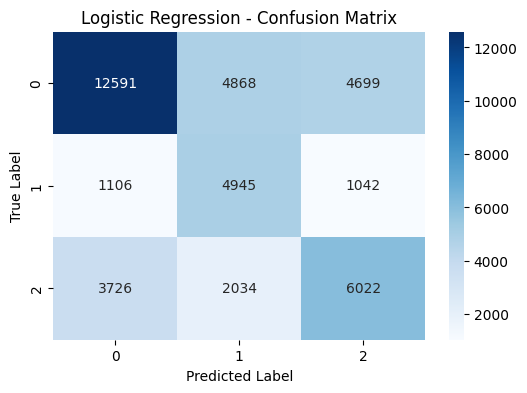

In [11]:
# Initialize Logistic Regression
# Increased max_iter might be needed for convergence with scaled data
logistic_regression = LogisticRegression(
    solver='lbfgs',
    penalty='l2',
    random_state=RANDOM_STATE,
    max_iter=1000 # Increased max_iter
)

# Evaluate the model
evaluate_classification(logistic_regression, X_train_final, y_train_final, X_test_final, y_test, cv=CV_FOLDS, model_name="Logistic Regression")


## Random Forest ##


--- Evaluating Random Forest ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     22158
           1       0.72      0.98      0.83      7093
           2       0.95      0.93      0.94     11782

    accuracy                           0.91     41033
   macro avg       0.89      0.93      0.90     41033
weighted avg       0.93      0.91      0.92     41033


Cross-Validation Scores (Accuracy, 5-fold):
[0.92699708 0.92927055 0.93139468 0.92734633 0.93193613]
Mean CV Accuracy: 0.9294 (+/- 0.0040)

Confusion Matrix (Test Set):
[[19512  2048   598]
 [   76  6982    35]
 [  171   604 11007]]


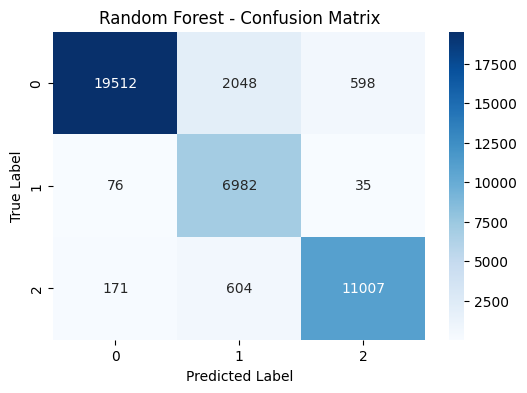

In [12]:
# Initialize Random Forest
random_forest = RandomForestClassifier(
    n_estimators=100, # A reasonable number of trees
    criterion='gini',
    max_depth=8,       # Keep max_depth as before or tune
    max_features='sqrt', # Common practice for RF ('log2' is also fine)
    random_state=RANDOM_STATE,
    class_weight='balanced_subsample' # Good for balanced data after SMOTE / imbalanced original data
)

# Evaluate the model
evaluate_classification(random_forest, X_train_final, y_train_final, X_test_final, y_test, cv=CV_FOLDS, model_name="Random Forest")


## Gradient Boosting Classifier ##


--- Evaluating Gradient Boosting (Sklearn) ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     22158
           1       0.76      0.97      0.85      7093
           2       0.89      0.92      0.90     11782

    accuracy                           0.90     41033
   macro avg       0.87      0.92      0.89     41033
weighted avg       0.91      0.90      0.90     41033


Cross-Validation Scores (Accuracy, 5-fold):
[0.91843399 0.91828337 0.91734209 0.91931628 0.91986605]
Mean CV Accuracy: 0.9186 (+/- 0.0017)

Confusion Matrix (Test Set):
[[19118  1771  1269]
 [  106  6899    88]
 [  485   449 10848]]


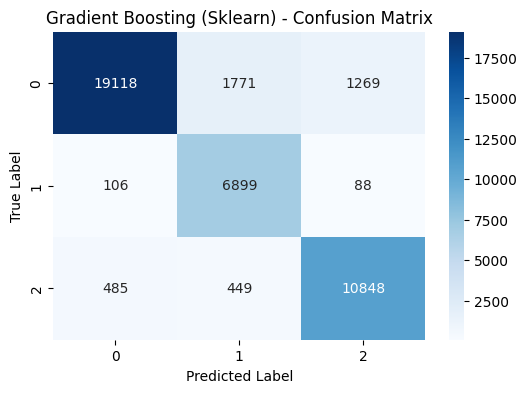

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting Classifier
# n_estimators: Number of boosting stages (trees) to perform.
# learning_rate: Shrinks the contribution of each tree. Lower values usually require more estimators.
# max_depth: Maximum depth of the individual regression estimators.
gradient_boosting = GradientBoostingClassifier(
    n_estimators=100, # Start with 100-300, tune as needed
    learning_rate=0.1, # Common starting point
    max_depth=3, # Often kept low (3-5) to prevent overfitting
    random_state=RANDOM_STATE
)

# Evaluate the model
evaluate_classification(gradient_boosting, X_train_final, y_train_final, X_test_final, y_test, cv=CV_FOLDS, model_name="Gradient Boosting (Sklearn)")


## XGBoost Classifier ##


--- Evaluating XGBoost Classifier ---


C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [00:38:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     22158
           1       0.64      0.95      0.77      7093
           2       0.86      0.86      0.86     11782

    accuracy                           0.84     41033
   macro avg       0.82      0.87      0.83     41033
weighted avg       0.87      0.84      0.85     41033


Cross-Validation Scores (Accuracy, 5-fold):


C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [00:38:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [00:38:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [00:38:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } 

[0.87056227 0.8699531  0.86823714 0.86743746 0.87390982]
Mean CV Accuracy: 0.8700 (+/- 0.0045)

Confusion Matrix (Test Set):
[[17723  2855  1580]
 [  204  6755   134]
 [  660   939 10183]]


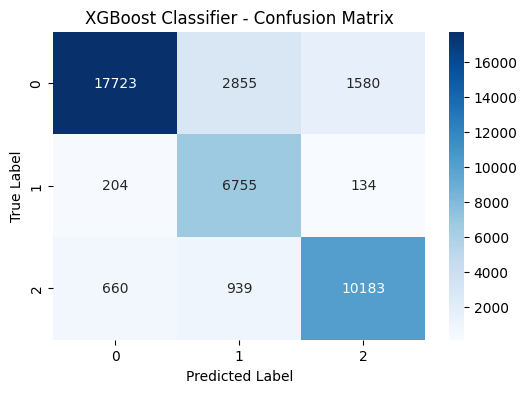

In [10]:
# Make sure you have installed xgboost: pip install xgboost
try:
    from xgboost import XGBClassifier

    # Initialize XGBoost Classifier
    # objective='multi:softmax': Specifies multi-class classification. Requires num_class.
    # num_class: The number of classes (3 in your case: no stress, time pressure, interruption).
    # use_label_encoder=False: Recommended practice with recent XGBoost versions.
    # eval_metric='mlogloss': Evaluation metric for multi-class classification during training (optional).
    xgb_classifier = XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y_train_final)), # Dynamically get number of classes
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        use_label_encoder=False, # Recommended
        eval_metric='mlogloss', # Common choice for multi-class logloss
        random_state=RANDOM_STATE
    )

    # Evaluate the model
    evaluate_classification(xgb_classifier, X_train_final, y_train_final, X_test_final, y_test, cv=CV_FOLDS, model_name="XGBoost Classifier")

except ImportError:
    print("XGBoost not installed. Skipping XGBoost evaluation.")
    print("Install using: pip install xgboost")


## LightGBM Classifier ##


--- Evaluating LightGBM Classifier ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8650
[LightGBM] [Info] Number of data points in the train set: 600246, number of used features: 34
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22158
           1       1.00      1.00      1.00      7093
           2       1.00      1.00      1.00     11782

    accuracy                           1.00     41033
   macro avg       1.00      1.00      1.00     41033
weighted avg       1.00      1.00      1.00     41033


Cross-Validation Scores (Accuracy, 5-fold):
[LightGBM] [Info] Auto-choosing col-wise multi-

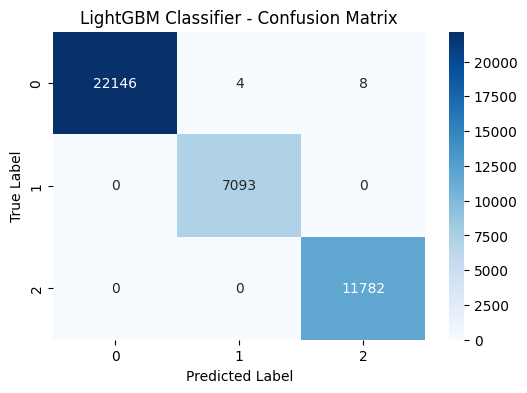

In [11]:
# Make sure you have installed lightgbm: pip install lightgbm
try:
    from lightgbm import LGBMClassifier

    # Initialize LightGBM Classifier
    # objective='multiclass': Specifies the task.
    # num_class: Number of classes.
    lgbm_classifier = LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train_final)),
        n_estimators=100,
        learning_rate=0.1,
        max_depth=-1, # Default: no limit (can set like XGBoost e.g., 3)
        # class_weight='balanced', # Option if needed
        random_state=RANDOM_STATE
    )

    # Evaluate the model
    # Note: LightGBM might issue warnings about feature names with special JSON characters if your original features had them.
    # It usually handles them okay, but renaming features to be simple alphanumeric can prevent this.
    evaluate_classification(lgbm_classifier, X_train_final, y_train_final, X_test_final, y_test, cv=CV_FOLDS, model_name="LightGBM Classifier")

except ImportError:
    print("LightGBM not installed. Skipping LightGBM evaluation.")
    print("Install using: pip install lightgbm")


## Multi-layer Perceptron (MLP) Classifier ##


--- Evaluating MLP Classifier ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22158
           1       1.00      1.00      1.00      7093
           2       1.00      1.00      1.00     11782

    accuracy                           1.00     41033
   macro avg       1.00      1.00      1.00     41033
weighted avg       1.00      1.00      1.00     41033


Cross-Validation Scores (Accuracy, 5-fold):
[1.         1.         1.         0.99998334 0.99999167]
Mean CV Accuracy: 1.0000 (+/- 0.0000)

Confusion Matrix (Test Set):
[[22157     0     1]
 [    0  7093     0]
 [    0     0 11782]]


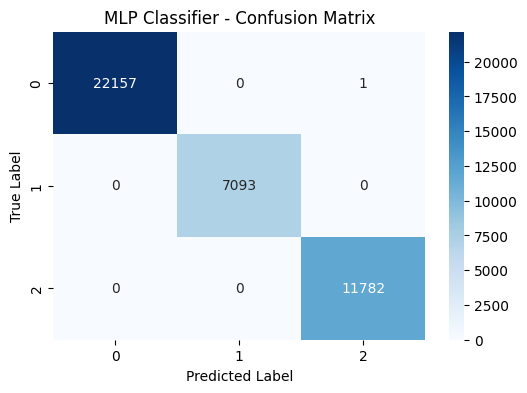

In [12]:
from sklearn.neural_network import MLPClassifier

# Initialize MLP Classifier
# hidden_layer_sizes: Defines the architecture (e.g., (100,) is one hidden layer with 100 neurons).
# activation: Activation function ('relu' is common).
# solver: Optimizer ('adam' is often effective).
# alpha: L2 penalty (regularization term).
# batch_size: Size of minibatches for stochastic optimizers.
# learning_rate_init: Initial learning rate.
# max_iter: Maximum number of iterations. Increase if the model doesn't converge.
# early_stopping: Can stop training early if validation score doesn't improve.
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100, 50), # Example: Two hidden layers
    activation='relu',
    solver='adam',
    alpha=0.0001, # Default regularization
    batch_size='auto',
    learning_rate_init=0.001,
    max_iter=500, # Increased iterations
    shuffle=True,
    random_state=RANDOM_STATE,
    early_stopping=True, # Use early stopping on validation set
    n_iter_no_change=10 # Stop if no improvement after 10 epochs
)

# Evaluate the model
# Note: MLP is sensitive to feature scaling, which we've already done.
evaluate_classification(mlp_classifier, X_train_final, y_train_final, X_test_final, y_test, cv=CV_FOLDS, model_name="MLP Classifier")
